<a href="https://colab.research.google.com/github/KangaOnGit/Domain_Conversion/blob/main/UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import torch
import torch.nn as nn

# **UNet**

Leaky ReLU was used instead of normal ReLU due to information loss when using ReLU.

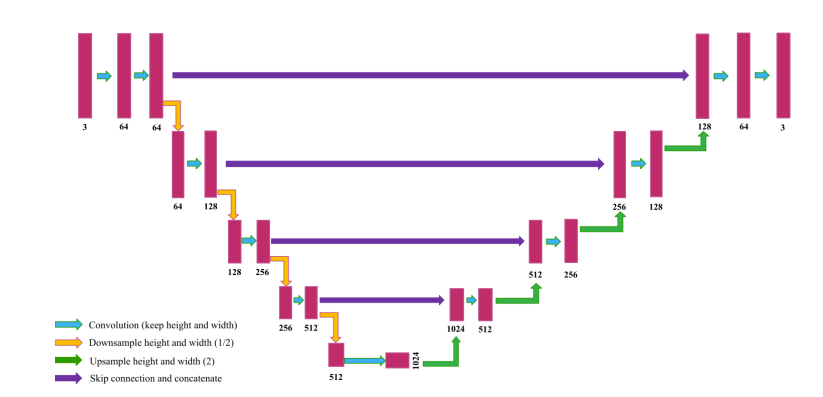

# **First Step**

In [7]:
class FirstStep(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(FirstStep, self).__init__()
    self.conv  = nn.Sequential(
        nn.Conv2d(in_channels, out_channels,
                  kernel_size = 1, stride = 1, padding = 0, bias = False),
        nn.LeakyReLU()
    )

    def forward(self, input):
      return self.conv(input)

# **ConvBlock**

In [8]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(ConvBlock, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels,
                  kernel_size = 3, stride = 1, padding = 1, bias = False),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(inplace = True),

        nn.Con2d(out_channels, out_channels,
                 kernel_size = 3, stride = 1, padding = 1, bias = False),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(inplace = True)
    )
    def forward(self, input):
      return self.conv(input)

# **Encoder Block**

In [9]:
class Encoder(nn.Module):
  def __init__(self, in_channels, out_channels) -> None:
    super(Encoder, self).__init__()
    # Downsample Height, Width to half the original
    self.encoder = nn.Sequential(
        nn.Maxpool2d(2),
        ConvBlock(in_channels, out_channels)
    )
    def forward(self, input):
      return self.encoder(input)

Nearest-Neighbor: Copies the value from the nearest pixel.

Bilinear: Uses all nearby pixels to calculate the pixel's value, using linear interpolations.

Bicubic: Again uses all nearby pixels to calculate the pixel's values, through polynomial interpolations. Usually produces a smoother surface than the previous techniques, but its harder to compute.

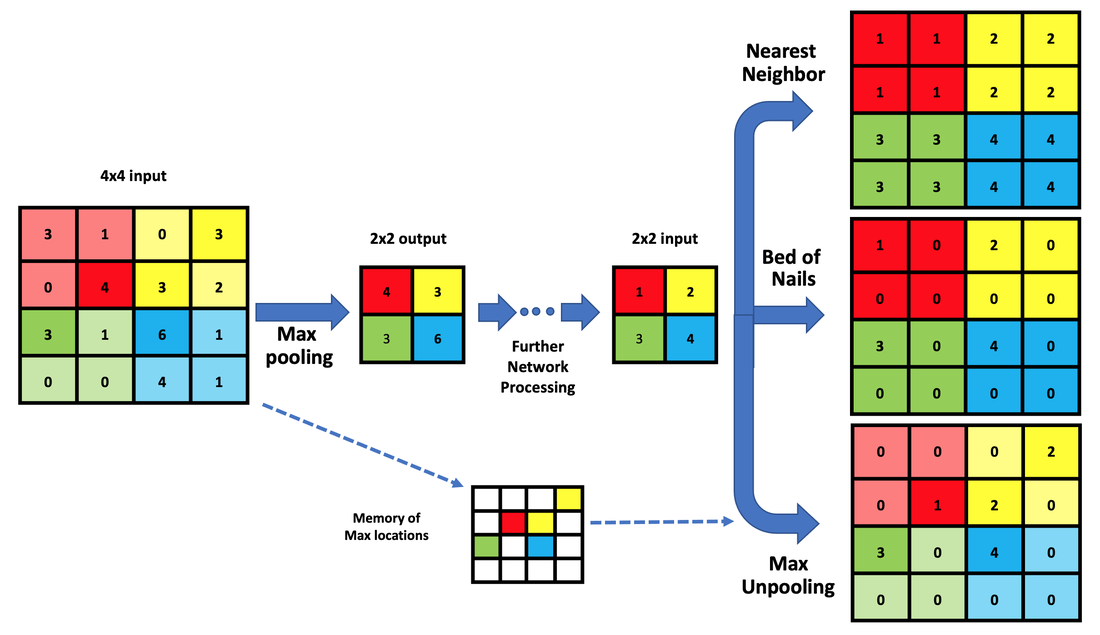

# **Decoder Block**

In [10]:
class Decoder(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(Decoder, self).__init__()
    self.decoder = nn.Sequentil(
        nn.UpsamplingBilinear2d(scale_factor = 2), # x2 Height and Width
        nn.Conv2d(in_channels, out_channels,
                  kernel_size = 1, stride = 1, paddig = 0, bias = False),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU()
    )
    self.conv_block = ConvBlock(in_channels, out_channels)

    def forward(self, input, skip):
      x = self.decoder(x)
      # Skip Connection (Save Resolution Information)
      x = torch.concat([x, skip], dim = 1)
      x = self.conv_block(x)
      return x

# **Final Step**

In [11]:
class FinalStep(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(FinalStep, self).init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size = 1,
                  stride = 1, padding = 0, bias = False),
        nn.Tanh() # Classification (-1, 1)
    )

  def forward(self, input):
    return self.conv(input)

# **UNet**

In [12]:
class UNet(nn.Module):
  def __init__(self, n_channels = 3, n_classes = 3,
               features = [64, 128, 256, 512]):
    super(UNet, self).__init__()

    self.n_channels = n_channels
    self.n_classes = n_classes

    self.in_conv1 = FirstStep(n_channels, 64)
    self.in_conv2 = ConvBlock(64, 64)

    self.enc_1 = Encoder(64, 128)
    self.enc_2 = Encoder(128, 258)
    self.enc_2 = Encoder(256, 512)
    self.enc_4 = Encoder(512, 1024)

    self.dec_1 = Decoder(1024, 512)
    self.dec_1 = Decoder(512, 256)
    self.dec_1 = Decoder(256, 128)
    self.dec_1 = Decoder(128, 64)

    self.out = FinalStep(64, n_classes)

  def forward(self, input):
    # First Step
    x = self.in_conv1(x)

    # Second Block
    x1 = self.in_conv2(x)

    # 4 Down Steps
    x2 = self.enc_1(x1)
    x3 = self.enc_2(x2)
    x4 = self.enc_3(x3)
    x5 = self.enc_4(x4)

    # 4 Up Steps
    x = self.dec_1(x5, x4)
    x = self.dec_1(x, x3)
    x = self.dec_1(x, x2)
    x = self.dec_1(x, x1)

    # Output
    x = self.out(x)

    return x